In [ ]:
import torch
from torch import nn
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
start_date = "2022-01-01"

In [ ]:
# Reads in MTA CSV file as a Pandas dataframe.
mta_dataset = pd.read_csv("mta.csv", parse_dates=["Date"])[["Date", "Subways: Total Estimated Ridership"]]
mta_dataset

,Date,Subways: Total Estimated Ridership,Subways: % of Comparable Pre-Pandemic Day
671,2022-01-01,1027918,0.38
672,2022-01-02,1219735,0.58
673,2022-01-03,2168229,0.42
674,2022-01-04,2289352,0.45
675,2022-01-05,2267942,0.44
...,...,...,...
1456,2024-02-25,1742005,0.79
1457,2024-02-26,3440336,0.63
1458,2024-02-27,3803092,0.70
1459,2024-02-28,3784529,0.70


In [ ]:
# Reads in NCEI CSV file as a Pandas dataframe.
weather_features = ["PRCP", "SNOW", "SNWD", "TAVG", "AWND"]
ncei_dataset = pd.read_csv("ncei.csv", parse_dates=["DATE"])[["DATE"] + weather_features]
# Removes all dates before start_date.
ncei_dataset = ncei_dataset[ncei_dataset["DATE"] >= start_date]
ncei_dataset

,DATE,PRCP,SNOW,SNWD,TAVG,AWND
671,2022-01-01,0.79,0.0,0.0,NaN,3.13
672,2022-01-02,0.04,0.0,0.0,NaN,5.82
673,2022-01-03,0.00,0.0,0.0,NaN,9.84
674,2022-01-04,0.00,0.0,0.0,NaN,6.04
675,2022-01-05,0.23,0.0,0.0,NaN,5.59
...,...,...,...,...,...,...
1451,2024-02-20,0.00,0.0,0.0,NaN,5.37
1452,2024-02-21,0.00,0.0,0.0,NaN,NaN
1453,2024-02-22,0.04,0.0,0.0,NaN,NaN
1454,2024-02-23,0.04,0.0,0.0,NaN,NaN


In [ ]:
# Removes all weekend days.
ncei_dataset = ncei_dataset[~ncei_dataset["DATE"].dt.dayofweek.isin([5, 6])]
ncei_dataset

In [ ]:
# Fills in all occurrences of not-a-number with zero.
ncei_dataset.fillna(0, inplace=True)
ncei_dataset

,DATE,PRCP,SNOW,SNWD,TAVG,AWND
671,2022-01-01,0.79,0.0,0.0,0.0,3.13
672,2022-01-02,0.04,0.0,0.0,0.0,5.82
673,2022-01-03,0.00,0.0,0.0,0.0,9.84
674,2022-01-04,0.00,0.0,0.0,0.0,6.04
675,2022-01-05,0.23,0.0,0.0,0.0,5.59
...,...,...,...,...,...,...
1451,2024-02-20,0.00,0.0,0.0,0.0,5.37
1452,2024-02-21,0.00,0.0,0.0,0.0,0.00
1453,2024-02-22,0.04,0.0,0.0,0.0,0.00
1454,2024-02-23,0.04,0.0,0.0,0.0,0.00


In [ ]:
# Ensures that the dates in the MTA dataset match those in the NCEI dataset.
mta_dataset = mta_dataset[mta_dataset["Date"].isin(ncei_dataset["DATE"])]
len(mta_dataset)

785

In [ ]:
# X and y will store both datasets without the date columns.
X, y = ncei_dataset.drop("DATE", axis=1), mta_dataset[["Subways: Total Estimated Ridership"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

# Convert to 2D PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

In [ ]:
# class LinearRegressionModel(torch.nn.Module):
#     def __init__(self, input_features, output_features):
#         super().__init__()
#         self.linear = torch.nn.Linear(input_features, output_features)

#     def forward(self, x):
#         return self.linear(x)
#
# model = LinearRegressionModel(input_features=len(weather_features), output_features=1)
#torch.nn.init.uniform_(linear_layer.weight)
model = nn.Sequential(
    nn.Linear(len(weather_features), 64),
    torch.nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 8),
    nn.ReLU(),
    nn.Linear(8, 4),
    nn.ReLU(),
    nn.Linear(4, 1)
).to(device)

# model.add_module('bn', nn.BatchNorm1d(1))

In [ ]:
def he_uniform(module):
    if isinstance(module, nn.Linear):
        # Calculate the gain for He uniform initialization
        gain = nn.init.calculate_gain('relu')
        # Initialize the weights and biases
        nn.init.xavier_uniform_(module.weight, gain=gain)
        if module.bias is not None:
            nn.init.constant_(module.bias, 0)

model = model.apply(he_uniform)
model

Sequential(
  (0): Linear(in_features=5, out_features=64, bias=True)
  (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Linear(in_features=64, out_features=32, bias=True)
  (4): ReLU()
  (5): Linear(in_features=32, out_features=16, bias=True)
  (6): ReLU()
  (7): Linear(in_features=16, out_features=8, bias=True)
  (8): ReLU()
  (9): Linear(in_features=8, out_features=4, bias=True)
  (10): ReLU()
  (11): Linear(in_features=4, out_features=1, bias=True)
)

In [ ]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

MSE: 655619915776.00
RMSE: 809703.60


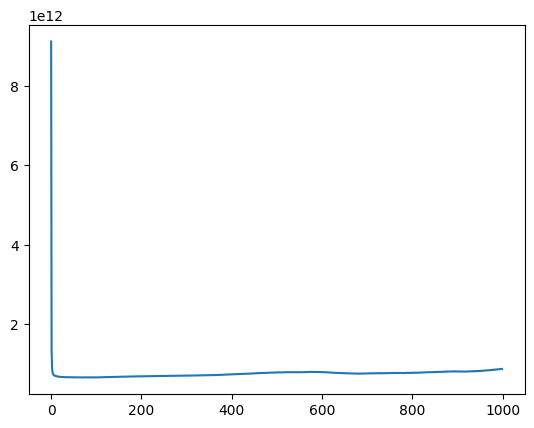

In [ ]:
import copy

import matplotlib.pyplot as plt
import numpy as np

n_epochs = 1000   # number of epochs to run
batch_size = 10  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)

# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []

for epoch in range(n_epochs):
    model.train()

    for start in batch_start:
        # take a batch
        X_batch = X_train[start:start+batch_size]
        y_batch = y_train[start:start+batch_size]
        # forward pass
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        # update weights
        optimizer.step()

    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())

# restore model and return best accuracy
if best_weights is not None:
    model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

In [ ]:
# weather_features = ["PRCP", "SNOW", "SNWD", "TAVG", "AWND"]

futures = [
    [0, 0, 0, 70, 1],
    [5, 0, 0, 40, 10],
    [3, 4, 4, 20, 5],
    [3, 6, 6, 15, 5],
    [4, 7, 5, 29, 0],
    [1, 0, 0, 60, 15],
    [7, 0, 0, 50, 15.5],
    [3, 4, 4, 0, 1],
    [5, 0, 0, 40, 5],
    [5, 0, 0, 70, 5]
]

# Sorts by temperature.
futures.sort(key=lambda row: row[3])

X_future = torch.Tensor(futures).to(device)

model.eval()
with torch.no_grad():
  y_future = model(X_future)

print("Precipitation\tSnowfall\tSnow depth\tAvg. temp\tAvg. wind speed\tPeople")
for future_conditions, future_prediction in zip(X_future, y_future):
  future_conditions = [round(value.item(), 2) for value in future_conditions]
  print(f"{future_conditions[0]}\t\t{future_conditions[1]}\t\t{future_conditions[2]}\t\t{future_conditions[3]}\t\t{future_conditions[4]}\t\t{int(future_prediction)}")

Precipitation	Snowfall	Snow depth	Avg. temp	Avg. wind speed	People
3.0		4.0		4.0		0.0		1.0		3307513
3.0		6.0		6.0		15.0		5.0		3463060
3.0		4.0		4.0		20.0		5.0		3684506
4.0		7.0		5.0		29.0		0.0		4733171
5.0		0.0		0.0		40.0		10.0		6320541
5.0		0.0		0.0		40.0		5.0		6139473
7.0		0.0		0.0		50.0		15.5		7802017
1.0		0.0		0.0		60.0		15.0		8531844
0.0		0.0		0.0		70.0		1.0		9508300
5.0		0.0		0.0		70.0		5.0		9316093


In [ ]:
# Saves PyTorch-related objects.
torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss}, 'pytorch_data')